# Myself Training in  Natural Network
> Myself training Project in ML [Graph Neural Network ]

 Created by [Farid Hossain ]().


In [ ]:
# We assume that PyTorch is already installed
import torch
torchversion = torch.__version__

# Install PyTorch Scatter, PyTorch Sparse, and PyTorch Geometric
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-{torchversion}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Numpy for matrices
import numpy as np
np.random.seed(0)

# Visualization
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 99.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 51.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


# Dataset

In [ ]:
from torch_geometric.datasets import Planetoid

# Import dataset from PyTorch Geometric
dataset = Planetoid(root=".", name="CiteSeer")

data = dataset[0]

# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')

Processing...


Dataset: CiteSeer()
-------------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6

Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


Done!


In [ ]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 48


# Plot dataset

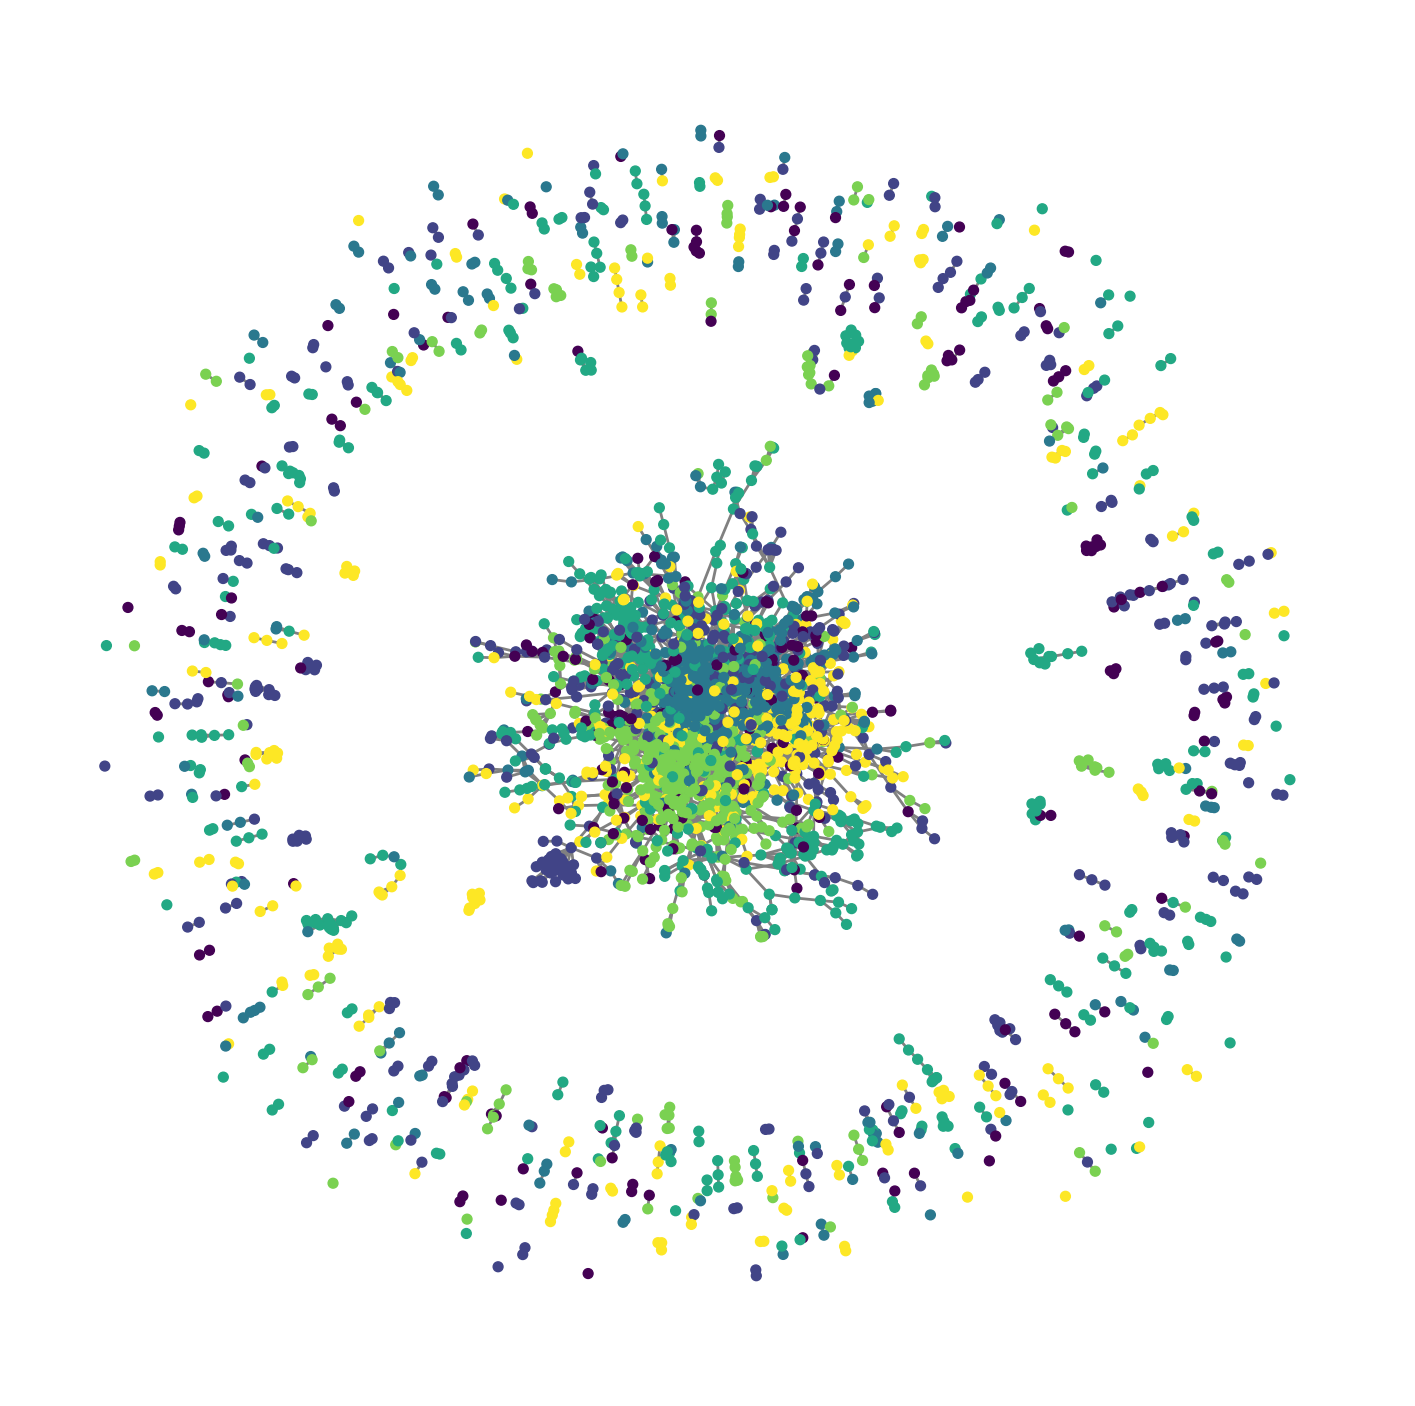

In [ ]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

# Plot node degrees

<BarContainer object of 32 artists>

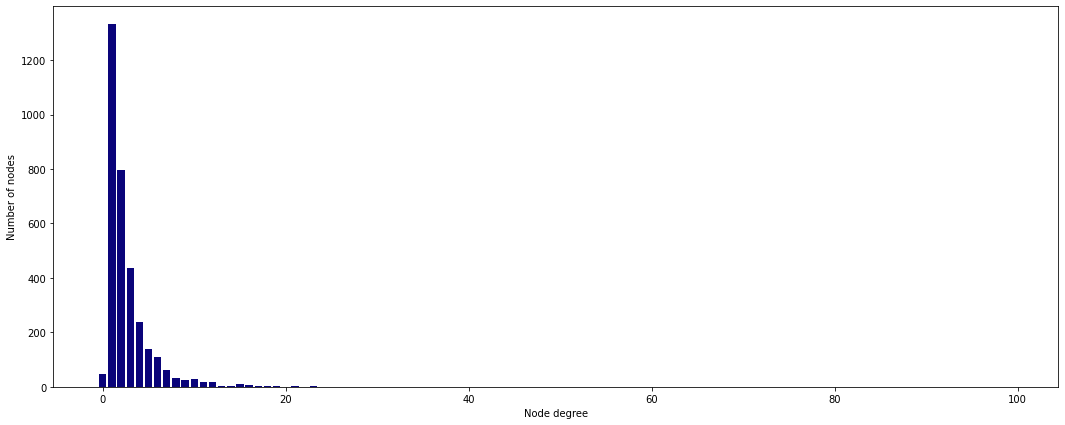

In [ ]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

# Implement GAT vs. GCN

In [ ]:
import torch
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
    """Graph Convolutional Network"""
    def __init__(self, dim_in, dim_h, dim_out):
        super().__init__()
        self.gcn1 = GCNConv(dim_in, dim_h)
        self.gcn2 = GCNConv(dim_h, dim_out)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.01,
                                          weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.5, training=self.training)
        h = self.gcn1(h, edge_index)
        h = torch.relu(h)
        h = F.dropout(h, p=0.5, training=self.training)
        h = self.gcn2(h, edge_index)
        return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
    """Graph Attention Network"""
    def __init__(self, dim_in, dim_h, dim_out, heads=8):
        super().__init__()
        self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
        self.gat2 = GATv2Conv(dim_h * heads, dim_out, heads=1)
        self.optimizer = torch.optim.Adam(self.parameters(),
                                          lr=0.005,
                                          weight_decay=5e-4)

    def forward(self, x, edge_index):
        h = F.dropout(x, p=0.6, training=self.training)
        h = self.gat1(x, edge_index)
        h = F.elu(h)
        h = F.dropout(h, p=0.6, training=self.training)
        h = self.gat2(h, edge_index)
        return h, F.log_softmax(h, dim=1)


def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()


def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs + 1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if epoch % 10 == 0:
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')

    return model


def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc


# Train GCN

In [ ]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.799 | Train Acc:  15.00% | Val Loss: 1.80 | Val Acc: 13.20%
Epoch  10 | Train Loss: 0.543 | Train Acc:  90.00% | Val Loss: 1.28 | Val Acc: 57.20%
Epoch  20 | Train Loss: 0.176 | Train Acc:  97.50% | Val Loss: 1.36 | Val Acc: 56.40%
Epoch  30 | Train Loss: 0.082 | Train Acc:  99.17% | Val Loss: 1.42 | Val Acc: 55.00%
Epoch  40 | Train Loss: 0.044 | Train Acc:  99.17% | Val Loss: 1.60 | Val Acc: 54.80%
Epoch  50 | Train Loss: 0.036 | Train Acc: 100.00% | Val Loss: 1.46 | Val Acc: 56.80%
Epoch  60 | Train Loss: 0.051 | Train Acc:  99.17% | Val Loss: 1.47 | Val Acc: 58.20%
Epoch  70 | Train Loss: 0.039 | Train Acc: 100.00% | Val Loss: 1.51 | Val Acc: 57.40%
Epoch  80 | Train Loss: 0.055 | Train Acc:  99.17% | Val Loss: 1.49 | Val Acc: 58.40%
Epoch  90 | Train Loss: 0.049 | Train Acc:  99.17% | Val Loss: 1.48 | Val Acc: 60.80%
Epoch 100 | Train Loss: 0.046 | Train Acc:  99.17% | Val Loss: 1.53 | Val Acc: 5

# Train GAT

In [ ]:
%%time

# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train
train(gat, data)

# Test
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.811 | Train Acc:  15.00% | Val Loss: 1.80 | Val Acc: 14.60%
Epoch  10 | Train Loss: 0.123 | Train Acc:  97.50% | Val Loss: 1.05 | Val Acc: 66.00%
Epoch  20 | Train Loss: 0.031 | Train Acc:  99.17% | Val Loss: 1.17 | Val Acc: 64.40%
Epoch  30 | Train Loss: 0.033 | Train Acc:  99.17% | Val Loss: 1.26 | Val Acc: 64.80%
Epoch  40 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.23 | Val Acc: 65.60%
Epoch  50 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.21 | Val Acc: 65.40%
Epoch  60 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.17 | Val Acc: 67.80%
Epoch  70 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.09 | Val Acc: 67.40%
Epoch  80 | Train Loss: 0.008 | Train Acc: 100.00% | Val Loss: 1.12 | Val Acc: 66.60%
Epoch  90 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 66.00%
Epoch 100 | Train Loss: 0.008 | Train Acc: 100.00% | Val Lo

# t-SNE plots

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


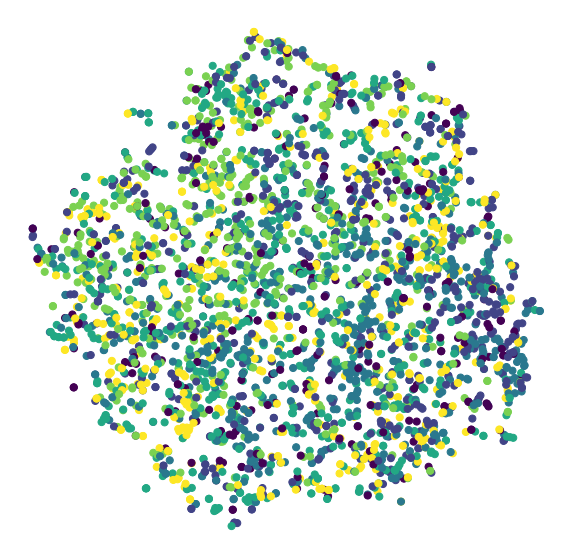

In [ ]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


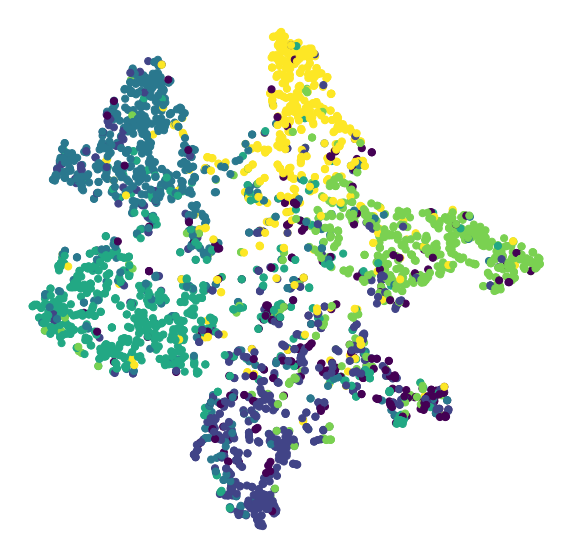

In [ ]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

# Plot accuracy for each node degree

Epoch   0 | Train Loss: 1.791 | Train Acc:  20.83% | Val Loss: 1.79 | Val Acc: 22.20%
Epoch  10 | Train Loss: 0.012 | Train Acc: 100.00% | Val Loss: 1.23 | Val Acc: 65.00%
Epoch  20 | Train Loss: 0.000 | Train Acc: 100.00% | Val Loss: 1.45 | Val Acc: 66.20%
Epoch  30 | Train Loss: 0.001 | Train Acc: 100.00% | Val Loss: 1.43 | Val Acc: 66.40%
Epoch  40 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.31 | Val Acc: 66.80%
Epoch  50 | Train Loss: 0.003 | Train Acc: 100.00% | Val Loss: 1.22 | Val Acc: 68.20%
Epoch  60 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.19 | Val Acc: 67.20%
Epoch  70 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 68.20%
Epoch  80 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 1.10 | Val Acc: 68.40%
Epoch  90 | Train Loss: 0.005 | Train Acc: 100.00% | Val Loss: 1.12 | Val Acc: 68.80%
Epoch 100 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 1.11 | Val Acc: 70.00%
Epoch 110 | Train Loss: 0.005 | Train Acc: 100.00% | V

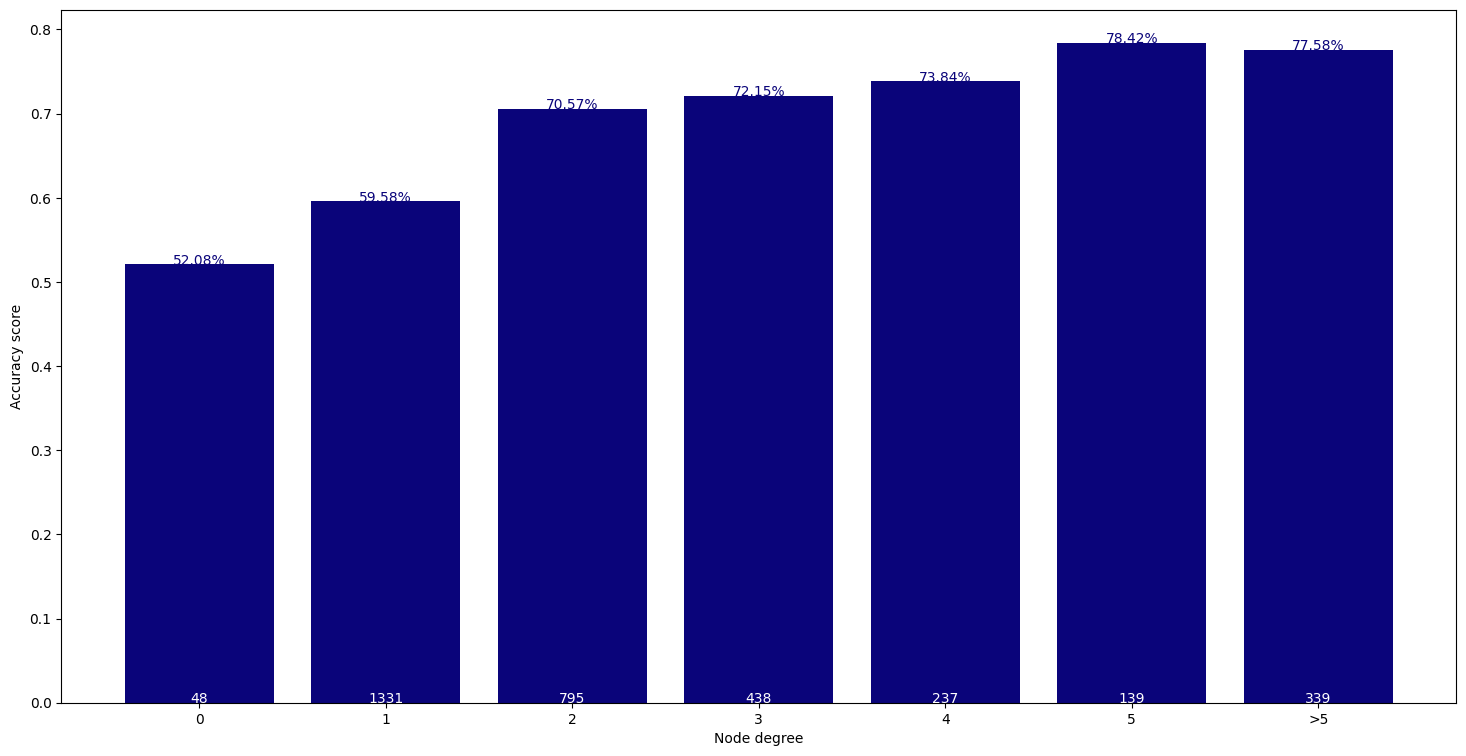

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from torch_geometric.utils import degree

# Initialize the GAT model
dim_in = data.x.size(1)  # Number of input features
dim_h = 32  # Hidden dimension size
dim_out = len(data.y.unique())  # Number of classes
gat = GAT(dim_in=dim_in, dim_h=dim_h, dim_out=dim_out)

# Train the GAT model
gat = train(gat, data)

# Get model's classifications
_, out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
    mask = np.where(degrees == i)[0]
    if len(mask) > 0:  # Check if there are nodes with this degree
        accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
        sizes.append(len(mask))
    else:
        accuracies.append(0.0)
        sizes.append(0)

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
if len(mask) > 0:  # Check if there are nodes with a degree > 5
    accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
    sizes.append(len(mask))
else:
    accuracies.append(0.0)
    sizes.append(0)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0', '1', '2', '3', '4', '5', '>5'],
        accuracies,
        color='#0A047A')

for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
    plt.text(i, accuracies[i] // 2, sizes[i],
             ha='center', color='white')

plt.show()
